In [1]:
import re
import os
import numpy as np
import pandas as pd
from sklearn import tree, metrics, model_selection
from sklearn.tree import _tree

In [2]:
if 'notebooks' in os.path.abspath(os.curdir):
    PROJ_DIR = os.path.join(os.path.abspath(os.curdir), '..')
else:
    PROJ_DIR = os.path.abspath(os.curdir)

In [3]:
PROJ_DIR

'/Users/shubhanshugupta/Desktop/aiforsea'

In [ ]:
import dask.dataframe as dd
features_df = dd.read_csv(PROJ_DIR + '/safety/features/*.csv')

In [ ]:
features_df.describe()

In [5]:
import glob

# glob.glob('data*.csv') - returns List[str]
# pd.read_csv(f) - returns pd.DataFrame()
# for f in glob.glob() - returns a List[DataFrames]
# pd.concat() - returns one pd.DataFrame()
df = pd.concat([pd.read_csv(f) for f in glob.glob(PROJ_DIR + '/safety/features/*.csv')], ignore_index = True)

In [6]:
df.shape

(16135561, 11)

In [7]:
df.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,1194000908341,4.000,203.000000,1.001973,9.745000,-0.790087,-0.066046,0.019175,0.044741,246.0,6.480000
1,1099511627891,3.000,311.000000,0.452518,9.273026,3.098191,0.005382,0.002155,-0.001436,66.0,0.340365
2,962072674446,10.000,142.807999,0.018542,-8.041156,-4.960114,0.004223,-0.014875,0.007397,1552.0,2.050000
3,1142461300867,8.000,171.205292,-0.290698,-8.295367,-3.049042,0.033618,0.046224,0.030559,277.0,17.608448
4,412316860548,19.379,0.000000,0.675613,8.846130,1.852508,-0.008652,0.003693,0.001160,148.0,0.000000


In [8]:
labels = pd.read_csv(PROJ_DIR + '/safety/labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv')

In [9]:
labels.head()

,bookingID,label
0,111669149733,0
1,335007449205,1
2,171798691856,0
3,1520418422900,0
4,798863917116,0


In [ ]:
df[df['bookingID'] == 1194000908341]

In [10]:
full_df = pd.merge(df, labels, on="bookingID")

In [12]:
full_df = full_df.sample(n=200000)

In [13]:
full_df['label'].value_counts()

0    138685
1     61315
Name: label, dtype: int64

In [ ]:
import matplotlib as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [ ]:
sns.countplot(x='label', data=full_df, palette='hls')
plt

In [14]:
y = full_df.label

In [15]:
X = full_df.drop(['label', 'bookingID'], axis=1)

In [16]:
X.head()

,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
8119537,16.687,79.0,-0.388596,8.347824,2.859970,-0.011536,-0.033188,0.001419,1500.0,17.660000
4908611,3.000,6.0,-0.130484,9.502586,2.431312,0.004887,0.001222,-0.003665,213.0,0.000000
14936083,8.000,8.0,1.098972,8.942616,-4.144490,0.033805,-0.054559,-0.043396,3.0,15.500422
11383285,3.900,284.0,-1.078110,8.957169,-0.553467,0.127426,0.026559,0.042584,122.0,10.960000
6344300,6.712,301.0,1.045778,9.443881,1.060009,-0.029810,0.030875,0.042586,851.0,6.853169


In [17]:
normalized_df=(X-X.min())/(X.max()-X.min())

In [18]:
normalized_df.head()

,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
8119537,0.002626,0.219449,0.427113,0.489744,0.476683,0.517366,0.603968,0.618061,2.422029e-06,0.478647
4908611,0.000371,0.016667,0.432263,0.503827,0.471274,0.517857,0.604330,0.617802,3.439282e-07,0.042476
14936083,0.001195,0.022223,0.456794,0.496998,0.388297,0.518721,0.603743,0.615779,4.844059e-09,0.425309
11383285,0.000519,0.788904,0.413356,0.497175,0.433611,0.521519,0.604597,0.620157,1.969917e-07,0.313169
6344300,0.000982,0.836127,0.455732,0.503111,0.453970,0.516820,0.604643,0.620157,1.374098e-06,0.211737


In [19]:
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve

In [21]:
#from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test=train_test_split(normalized_df,y,test_size=0.25,random_state=0)

In [22]:
features = list(X_train.columns)

In [23]:
RSEED = 50

# Create the model with 100 trees
rf_model = RandomForestClassifier(n_estimators=100,  random_state=RSEED,  max_features = 'sqrt', n_jobs=-1, verbose = 1)

# Fit on training data
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   40.7s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=50, verbose=1, warm_start=False)

In [25]:
n_nodes = []
max_depths = []

for ind_tree in rf_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print('Average number of nodes') + str(int(np.mean(n_nodes)))
print('Average maximum depth') + str(int(np.mean(max_depths)))

Average number of nodes50825
Average maximum depth76


In [26]:
train_rf_predictions = rf_model.predict(X_train)
train_rf_probs = rf_model.predict_proba(X_train)[:, 1]

rf_predictions = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [31]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5

    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print 'Baseline: ' + str(round(baseline[metric], 2))
        print 'Test: ' + str(round(results[metric], 2))
        print 'Train: ' + str(round(train_results[metric], 2))
#         print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

Baseline: 1.0
Test: 0.17
Train: 1.0
Baseline: 0.31
Test: 0.73
Train: 1.0
Baseline: 0.5
Test: 0.65
Train: 1.0


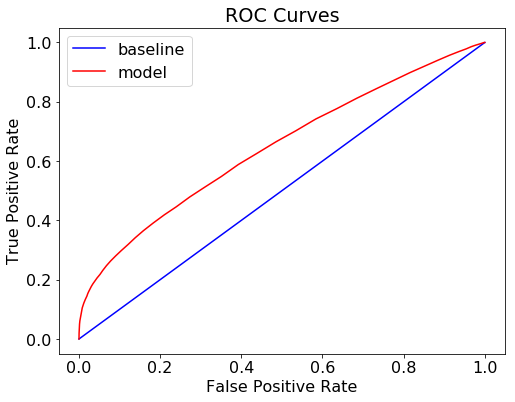

In [32]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [33]:
auc = roc_auc_score(y_test, rf_probs)
auc

0.6450969243644681